<h1 align='center' style=\"margin-bottom: 0px\"> Multi-Modal Genre Classification for Movies </h1>
<h2 align='center' style=\"margin-top: 0px\"> INFO 7390 Advances in Data Science and Architecture</h2>
<h4 align='center' style=\"margin-top: 0px\"> DEEP BHALODIA &nbsp; &nbsp;&nbsp; KEVAL SHAH &nbsp;&nbsp;&nbsp; PALASH BHIVGADE</h4>                             

# Overview

### Project Outline



* Scraping a dataset : The first step is to build a rich data set. We will collect textual and visual data for each movie
* Data pre-processing
* Non-deep Machine Learning models for Text
* Deep Models for Visual Data
* Deep Models for Text

#### What do we really mean?

 * Our task is to use available data to learn a function which can assign a category to a data point. For example, assign a genre to a movie, like "Romantic Comedy", "Action", "Thriller".
 * In machine learning community, the term Multi-Modal is used to refer to multiple kinds of data.
 * For this project, we will be using visual and textual data to classify movie genres.


## Section 1. Building our DataSet.


### We will be scrapping Data from two sources

#### IMDB:http://www.imdb.com/
* For those unaware, IMDB is the primary source of information about movies on the internet. It is immensely rich with posters, reviews, synopsis, ratings and many other information on every movie. We will use this as our primary data source.

#### TMDB:https://www.themoviedb.org/
* TMDB, or The Movie DataBase, is an open source version of IMDB, with a free to use API that can be used to collect information. You do need an API key, but it can be obtained for free by just making a request after making a free account.

In [118]:
%matplotlib inline
from urllib.request import urlopen
import urllib3
import requests
import json
from imdb import IMDb
import time
import itertools
import wget
import os
import os.path
import tmdbsimple as tmdb
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import SpectralCoclustering


In [119]:
#setting the path for the scraped folders to be saved
poster_folder='posters_final/'
if poster_folder.split('/')[0] in os.listdir('./'):
    print('Folder already exists')
else:
    os.mkdir('./'+poster_folder)


Folder already exists


In [120]:
api_key = '4ac92516d1a26e9b27ca010eeaf1d958'
tmdb.API_KEY = api_key 
search = tmdb.Search()

In [121]:
#Functions that take in a movie and return ID, Genre, info and Posters
def get_poster(movie):
    response = search.movie(query=movie)
    id=response['results'][0]['id']
    movie = tmdb.Movies(id)
    posterpath=movie.info()['poster_path']
    title=movie.info()['original_title']
    url='http://image.tmdb.org/t/p/original'+posterpath
    title='_'.join(title.split(' '))
    r = requests.get(url)
    completeName = os.path.join(poster_folder, title) 
    with open(completeName,'wb') as w:
        w.write(r.content)

def getmovie_id(movie):
    resp= search.movie(query=movie)
    movie_id=resp['results'][0]['id']
    return movie_id

def getmovie_info(movie):
    resp= search.movie(query=movie)
    id=resp['results'][0]['id']
    movie = tmdb.Movies(id)
    info=movie.info()
    return info

def getmovie_genre(movie):
    resp = search.movie(query=movie)
    id=resp['results'][0]['id']
    movie = tmdb.Movies(id)
    genres=movie.info()['genres']
    return genres

In [122]:
print (getmovie_genre("Logan"))

[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 878, 'name': 'Science Fiction'}]


In [123]:
print (getmovie_info("Beauty and the Beast"))

{'adult': False, 'backdrop_path': '/6aUWe0GSl69wMTSWWexsorMIvwU.jpg', 'belongs_to_collection': None, 'budget': 160000000, 'genres': [{'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10749, 'name': 'Romance'}], 'homepage': 'http://movies.disney.com/beauty-and-the-beast-2017', 'id': 321612, 'imdb_id': 'tt2771200', 'original_language': 'en', 'original_title': 'Beauty and the Beast', 'overview': "A live-action adaptation of Disney's version of the classic tale of a cursed prince and a beautiful young woman who helps him break the spell.", 'popularity': 132.065596, 'poster_path': '/tWqifoYuwLETmmasnGHO7xBjEtt.jpg', 'production_companies': [{'id': 2, 'logo_path': '/wszlOmgJykJXULYfuusu3Kxala4.png', 'name': 'Walt Disney Pictures', 'origin_country': 'US'}, {'id': 10227, 'logo_path': None, 'name': 'Mandeville Films', 'origin_country': ''}], 'production_countries': [{'iso_3166_1': 'US', 'name': 'United States of America'}], 'release_date': '2017-03-16', 'revenue': 126352112

In [124]:
info=getmovie_info("The Matrix")
print ("All the Movie information gets stored in a dictionary with the keys for easy access -")
info.keys()

All the Movie information gets stored in a dictionary with the keys for easy access -


dict_keys(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count'])

In [125]:
print (info['tagline'])

Welcome to the Real World.


In [126]:
#To create a dictionary of all the possible genres
genres=tmdb.Genres()
list_of_genres=genres.movie_list()

x=list_of_genres['genres']
Genre_ID_to_name={}
for i in range(len(x)):
    genre_id=x[i]['id']
    movie_genre_name=x[i]['name']
    Genre_ID_to_name[genre_id]=movie_genre_name

In [10]:
movies = []
baseyear = 2017

print('Started pulling movies..')
done_movies_ids=[]
for id in Genre_ID_to_name:
    baseyear -= 1
    for page in range(1,6,1):
        time.sleep(0.5)
    
        url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key
        url += '&language=en-US&sort_by=popularity.desc&year=' + str(baseyear) 
        url += '&with_genres=' + str(id) + '&page=' + str(page)

        f=urlopen(url) 
        data = f.read()

        dataDict = json.loads(data)
        movies.extend(dataDict["results"])
    done_movies_ids.append(str(id))
print("Pulled movies for genres - "+','.join(done_movies_ids))


Starting pulling movies from TMDB. This will take a while, please wait...
Pulled movies for genres - 28,12,16,35,80,99,18,10751,14,36,27,10402,9648,10749,878,10770,53,10752,37


In [11]:
file=open("movies_",'wb')
pickle.dump(movies,file)
file.close()

In [127]:
file=open("movies_",'rb')
movies=pickle.load(file)
file.close()

In [128]:
# This function just generates all possible pairs of movies
def pairs(l):
    pairs = list(itertools.combinations(l, 2))
    for i in l:
        pairs.append([i,i])
    return pairs


In [129]:
all_pairs = []
for movie in movies:
    all_pairs.extend(pairs(movie['genre_ids']))
    
unique_pairs = np.unique(all_pairs)
movie_Grid = np.zeros((len(unique_pairs), len(unique_pairs)))
for p in all_pairs:
    movie_Grid[np.argwhere(unique_pairs==p[0]), np.argwhere(unique_pairs==p[1])]+=1
    if p[1] != p[0]:
        movie_Grid[np.argwhere(unique_pairs==p[1]), np.argwhere(unique_pairs==p[0])]+=1
        

print (movie_Grid.shape)
print (len(Genre_ID_to_name.keys()))

(20, 20)
19


In [130]:
for i in (unique_pairs):
    if i not in Genre_ID_to_name.keys():
        print (i)


10769


In [131]:
Genre_ID_to_name[10769]="Foreign" 

len(Genre_ID_to_name.keys())


20

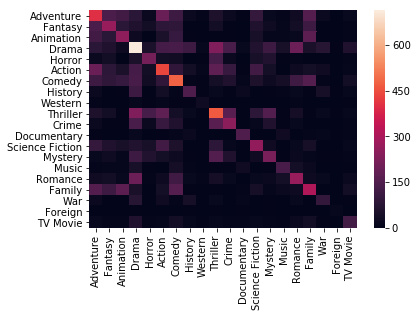

In [112]:
lookup = []
for i in range(len(nr_movies_ids)):
    lookup.append(Genre_ID_to_name[nr_movies_ids[i]])

sns.heatmap(movie_Grid, xticklabels=lookup, yticklabels=lookup)


In [132]:
movie_ids = [m['id'] for m in movies]
print ("originally we had ",len(movie_ids)," movies")
movie_ids=np.unique(movie_ids)
print (len(movie_ids))
seen_before=[]
no_duplicate_movies=[]
for i in range(len(movies)):
    movie=movies[i]
    id=movie['id']
    if id in seen_before:
        continue
    else:
        seen_before.append(id)
        no_duplicate_movies.append(movie)
print ("After removing duplicates we have ",len(no_duplicate_movies), " movies")


originally we had  1759  movies
1688
After removing duplicates we have  1688  movies


In [18]:
file=open("movies_final",'wb')
pickle.dump(no_duplicate_movies,file)
file.close()

In [21]:
#file=open("movies_final",'rb')
#movies=pickle.load(file)
#file.close()

In [ ]:
poster_movies=[]
counter=0
movies_no_poster=[]
print("Total movies : ",len(no_duplicate_movies))
print("Started downloading posters...")
for movie in no_duplicate_movies:
    id=movie['id']
    title=movie['title']
    if counter==1:
        print('Downloaded first!')
    if counter%300==0 and counter!=0:
        print ("Done with ",counter," movies!")
        print ("Trying to get poster for ",title)
    try:
        get_poster_tmdb(title)
        poster_movies.append(movie)
    except:
        try:
            time.sleep(7)
            get_poster(title)
            poster_movies.append(movie)
        except:
            movies_no_poster.append(movie)
    counter+=1
print("Done with all the posters!")


f=open('poster_movies.pckl','wb')
pickle.dump(poster_movies,f)
f.close()

f=open('no_poster_movies.pckl','wb')
pickle.dump(movies_no_poster,f)
f.close()

In [133]:
g=open('poster_movies.pckl','rb')
poster_movies=pickle.load(g)
g.close()

f=open('no_poster_movies.pckl','rb')
movies_no_poster=pickle.load(f)
f.close()

In [134]:
movies_with_overviews=[]
for i in range(len(poster_movies)):
    movie=poster_movies[i]
    id=movie['id']
    overview=movie['overview']
    
    if len(overview)==0:
        continue
    else:
        movies_with_overviews.append(movie)
        
len(movies_with_overviews)

1645

In [135]:
genres_n=[]
all_ids=[]
for i in range(len(movies_with_overviews)):
    movie=movies_with_overviews[i]
    id=movie['id']
    genre_ids=movie['genre_ids']
    genres_n.append(genre_ids)
    all_ids.extend(genre_ids)
    

In [136]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb=MultiLabelBinarizer()
Y=mlb.fit_transform(genres_n)

print (Y.shape)
print (np.sum(Y, axis=0))


(1645, 20)
[364 247 232 674 206 412 444 132  24 442 239 139 246 202 130 252 282  85
  12 105]


In [137]:
from sklearn.feature_extraction.text import CountVectorizer


movie_content=[]
for i in range(len(movies_with_overviews)):
    movie=movies_with_overviews[i]
    id=movie['id']
    overview=movie['overview']
    overview=overview.replace(',','')
    overview=overview.replace('.','')
    movie_content.append(overview)
    
    


In [138]:
sample_movie=movies_with_overviews[5]
sample_overview=sample_movie['overview']
sample_title=sample_movie['title']
print ("The overview for the movie",sample_title," is - \n\n")
print (sample_overview)

The overview for the movie Captain America: Civil War  is - 


Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarizes opinion amongst the Avengers, causing two factions to side with Iron Man or Captain America, which causes an epic battle between former allies.


In [139]:
print (movie_content[0])
print (len(movie_content))

A young street magician is left to take care of his little sister after his mother's passing and turns to drug dealing in the Los Angeles party scene to keep a roof over their heads When he gets into trouble with his supplier his sister is kidnapped and he is forced to rely on both his sleight of hand and brilliant mind to save her
1645


In [140]:
vectorize=CountVectorizer(max_df=0.95, min_df=0.005)
X=vectorize.fit_transform(movie_content)


In [141]:
X.shape

(1645, 1228)

In [142]:
f4=open('X.pckl','wb')
f5=open('Y.pckl','wb')
f6=open('Genredict.pckl','wb')
pickle.dump(X,f4)
pickle.dump(Y,f5)
pickle.dump(Genre_ID_to_name,f6)
f4.close()
f5.close()
f6.close()

In [143]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)
X_tfidf.shape

(1645, 1228)

In [144]:
msk = np.random.rand(X_tfidf.shape[0]) < 0.8

X_train_tfidf=X_tfidf[msk]
X_test_tfidf=X_tfidf[~msk]
Y_train=Y[msk]
Y_test=Y[~msk]
positions=range(len(movies_with_overviews))
# print positions
test_movies=np.asarray(positions)[~msk]
# test_movies

In [145]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

In [146]:
parameters = {'kernel':['linear'], 'C':[0.01, 0.1, 1.0]}
gridCV = GridSearchCV(SVC(class_weight='balanced'), parameters, scoring=make_scorer(f1_score, average='micro'))
classif = OneVsRestClassifier(gridCV)

classif.fit(X_train_tfidf, Y_train)

OneVsRestClassifier(estimator=GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)...fit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=micro), verbose=0),
          n_jobs=1)

In [147]:
genre_names = Genre_ID_to_name.values()
print(genre_names)

dict_values(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'Foreign'])


In [148]:
predstfidf=classif.predict(X_test_tfidf)

print (classification_report(Y_test, predstfidf, target_names=genre_names))

                 precision    recall  f1-score   support

         Action       0.45      0.64      0.53        69
      Adventure       0.29      0.49      0.36        41
      Animation       0.38      0.49      0.43        43
         Comedy       0.56      0.61      0.59       137
          Crime       0.37      0.44      0.40        43
    Documentary       0.43      0.59      0.50        74
          Drama       0.40      0.56      0.47        77
         Family       0.36      0.35      0.36        34
        Fantasy       0.50      0.33      0.40         6
        History       0.50      0.58      0.54        89
         Horror       0.32      0.50      0.39        40
          Music       0.57      0.62      0.60        32
        Mystery       0.70      0.43      0.54        44
        Romance       0.42      0.60      0.49        42
Science Fiction       0.89      0.59      0.71        27
       TV Movie       0.45      0.58      0.51        52
       Thriller       0.00    

/Users/deep/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/deep/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [149]:
f=open('classifer_svc','wb')
pickle.dump(classif,f)
f.close()

In [150]:
genre_list=sorted(list(Genre_ID_to_name.keys()))

In [151]:
movie_predictions=[]
for i in range(X_test_tfidf.shape[0]):
    pred_genres=[]
    movie_label_scores=predstfidf[i]
#     print movie_label_scores
    for j in range(20):
        #print j
        if movie_label_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            pred_genres.append(genre)
    movie_predictions.append(pred_genres)

In [152]:
for i in range(X_test_tfidf.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[i]['title'],'\tPREDICTION: ',','.join(movie_predictions[i]))

MOVIE:  Mythica: The Godslayer 	PREDICTION:  Adventure,Fantasy,Drama,Action,Romance
MOVIE:  Terminator Genisys 	PREDICTION:  Documentary
MOVIE:  Asterix: The Mansions of the Gods 	PREDICTION:  Adventure,Drama,Mystery
MOVIE:  The Garden of Words 	PREDICTION:  Drama,Horror,Comedy
MOVIE:  Star Wars Rebels: Spark of Rebellion 	PREDICTION:  Drama,Crime,Mystery,Romance
MOVIE:  EuroTrip 	PREDICTION:  Adventure,Drama,Thriller


### Naive Bayes

In [153]:
from sklearn.naive_bayes import MultinomialNB
classifnb = OneVsRestClassifier(MultinomialNB())
classifnb.fit(X[msk].toarray(), Y_train)
predsnb=classifnb.predict(X[~msk].toarray())


In [160]:
f2=open('classifer_nb','wb')
pickle.dump(classifnb,f2)
f2.close()

In [155]:
predictionsnb=[]
for i in range(X_test_tfidf.shape[0]):
    pred_genres=[]
    movie_label_scores=predsnb[i]
    for j in range(20):
        #print j
        if movie_label_scores[j]!=0:
            genre=Genre_ID_to_name[genre_list[j]]
            pred_genres.append(genre)
    predictionsnb.append(pred_genres)

In [156]:
for i in range(X_test_tfidf.shape[0]):
    if i%50==0 and i!=0:
        print ('MOVIE: ',movies_with_overviews[i]['title'],'\tPREDICTION: ',','.join(predictionsnb[i]))

MOVIE:  Mythica: The Godslayer 	PREDICTION:  Adventure,Fantasy,Drama,Romance
MOVIE:  Terminator Genisys 	PREDICTION:  History,Documentary,War
MOVIE:  Asterix: The Mansions of the Gods 	PREDICTION:  Drama,Comedy
MOVIE:  The Garden of Words 	PREDICTION:  Drama,Horror,Comedy,Romance
MOVIE:  Star Wars Rebels: Spark of Rebellion 	PREDICTION:  Drama,Comedy,Thriller,Crime,Romance
MOVIE:  EuroTrip 	PREDICTION:  Drama


## Evaluation

In [40]:
def movie_precision_recall(gt,preds):
    TP=0
    FP=0
    FN=0
    for t in gt:
        if t in preds:
            TP+=1
        else:
            FN+=1
    for p in preds:
        if p not in gt:
            FP+=1
    if TP+FP==0:
        precision=0
    else:
        precision=TP/float(TP+FP)
    if TP+FN==0:
        recall=0
    else:
        recall=TP/float(TP+FN)
    return precision,recall

In [158]:
precs=[]
recs=[]
for i in range(len(test_movies)):
    if i%1==0:
        pos=test_movies[i]
        test_movie=movies_with_overviews[pos]
        gtids=test_movie['genre_ids']
        gt=[]
        for g in gtids:
            g_name=Genre_ID_to_name[g]
            gt.append(g_name)
#         print predictions[i],movies_with_overviews[i]['title'],gt
        a,b=precision_recall(gt,movie_predictions[i])
        precs.append(a)
        recs.append(b)

print (np.mean(np.asarray(precs)),np.mean(np.asarray(recs)))

0.462406386887 0.525618199802


In [159]:
precs=[]
recs=[]
for i in range(len(test_movies)):
    if i%1==0:
        pos=test_movies[i]
        test_movie=movies_with_overviews[pos]
        gtids=test_movie['genre_ids']
        gt=[]
        for g in gtids:
            g_name=Genre_ID_to_name[g]
            gt.append(g_name)
#         print predictions[i],movies_with_overviews[i]['title'],gt
        a,b=precision_recall(gt,predictionsnb[i])
        precs.append(a)
        recs.append(b)

print (np.mean(np.asarray(precs)),np.mean(np.asarray(recs)))


0.498353822241 0.541790306627


### Applying Deep Learning on Movie Posters

In [4]:
import os;
print(os.getcwd()); 

C:\Users\Admin\Desktop\Advance Data Science & Architecture\Progress_Report


In [5]:
os.chdir('C:\\Users\Admin\Desktop\Advance Data Science & Architecture\Projectdata')

In [7]:
import pickle

In [8]:
posters = 'posters_final/'

In [9]:
f=open('poster_movies.pckl','rb')
poster_movies=pickle.load(f)
f.close()

In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pickle
model = VGG16(weights='imagenet', include_top=False)

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
allnames=os.listdir(posters)
imnames=[j for j in allnames]
feature_list=[]
genre_list=[]
file_order=[]
print ("Starting extracting VGG features for scraped images. This will take time, Please be patient...")
print ("Total images = ",len(imnames))
failed_files=[]
succesful_files=[]
i=0
for mov in poster_movies:
    i+=1
    mov_name=mov['original_title']
    mov_name1=mov_name.replace(':','/')
    poster_name=mov_name.replace(' ','_')
    if poster_name in imnames:
        img_path=posters+poster_name
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            succesful_files.append(imnames)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            features = model.predict(x)
            file_order.append(img_path)
            feature_list.append(features)
            genre_list.append(mov['genre_ids'])
            if np.max(np.asarray(feature_list))==0.0:
                print('problematic',i)
            if i%250==0 or i==1:
                print ("Working on Image : ",i)
        except:
            failed_files.append(imnames)
            continue
        
    else:
        continue
print ("Done with all features, please pickle for future use!")

Starting extracting VGG features for scraped images. This will take time, Please be patient...
Total images =  1652
Working on Image :  1
Working on Image :  250
Working on Image :  500
Working on Image :  1000
Working on Image :  1250
Working on Image :  1500
Done with all features, please pickle for future use!


In [12]:
len(genre_list)

len(feature_list)

1348

In [13]:
# Reading from pickle below, this code is not to be run.
movie_list_pickled=(feature_list,file_order,failed_files,succesful_files,genre_list)
f=open('posters_new_features.pckl','wb')
pickle.dump(movie_list_pickled,f)
f.close()
print("Features dumped to pickle file")

Features dumped to pickle file


In [14]:
f7=open('posters_new_features.pckl','rb')
list_pickled=pickle.load(f7)
f7.close()

In [15]:
(feature_list,files,failed,succesful,genre_list)=movie_list_pickled

In [16]:
(a,b,c,d)=feature_list[0].shape
feature_size=a*b*c*d

In [17]:
np_features=np.zeros((len(feature_list),feature_size))
for i in range(len(feature_list)):
    feat=feature_list[i]
    reshaped_feat=feat.reshape(1,-1)
    np_features[i]=reshaped_feat

In [18]:
X=np_features

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb=MultiLabelBinarizer()
Y=mlb.fit_transform(genre_list)

Y.shape

(1348, 20)

In [20]:
visual_problem_data=(X,Y)
f8=open('visual_problem_data_clean.pckl','wb')
pickle.dump(visual_problem_data,f8)
f8.close()

In [21]:
f8=open('visual_problem_data_clean.pckl','rb')
visual_features=pickle.load(f8)
f8.close()

In [22]:
(X,Y)=visual_features

In [23]:
X.shape

(1348, 25088)

In [24]:
mask = np.random.rand(len(X)) < 0.8

In [25]:
X_train=X[mask]
X_test=X[~mask]
Y_train=Y[mask]
Y_test=Y[~mask]

In [26]:
X_test.shape

(255, 25088)

In [ ]:
###Activation Function

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

In [28]:
model_visual = Sequential([
    Dense(1024, input_shape=(25088,)),
    Activation('relu'),
    Dense(256),
    Activation('relu'),
    Dense(20),
    Activation('sigmoid'),
])
opt = optimizers.rmsprop(lr=0.0001, decay=1e-6)


In [30]:
#sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.4, nesterov=False)
model_visual.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [31]:
model_visual.fit(X_train, Y_train, epochs=10, batch_size=64,verbose=1)

Epoch 1/10
1093/1093 [==============================] - 17s 16ms/step - loss: 2.2901 - acc: 0.8218
Epoch 2/10
1093/1093 [==============================] - 13s 12ms/step - loss: 1.5598 - acc: 0.8668
Epoch 3/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.9468 - acc: 0.9001
Epoch 4/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.4743 - acc: 0.9386
Epoch 5/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.2327 - acc: 0.9695
Epoch 6/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.1474 - acc: 0.9842
Epoch 7/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.1254 - acc: 0.9874
Epoch 8/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.1156 - acc: 0.9882
Epoch 9/10
1093/1093 [==============================] - 13s 12ms/step - loss: 0.1029 - acc: 0.9906
Epoch 10/10
1093/1093 [==============================] - 14s 13ms/step - loss: 0.1100 - acc: 0.9896


In [32]:
model_visual.fit(X_train, Y_train, epochs=50, batch_size=64,verbose=0)

In [33]:
Y_preds=model_visual.predict(X_test)

In [34]:
sum(sum(Y_preds))

436.87544748611253

In [35]:
f6=open('Genredict.pckl','rb')
Genre_ID_to_name=pickle.load(f6)
f6.close()

In [36]:
sum(Y_preds[1])

1.0023755041719091

In [37]:
sum(Y_preds[2])

0.968328666690122

In [38]:
genre_list=sorted(list(Genre_ID_to_name.keys()))

In [41]:
precs=[]
recs=[]
for i in range(len(Y_preds)):
    row=Y_preds[i]
    gt_genres=Y_test[i]
    gt_genre_names=[]
    for j in range(20):
        if gt_genres[j]==1:
            gt_genre_names.append(Genre_ID_to_name[genre_list[j]])
    top_3=np.argsort(row)[-3:]
    predicted_genres=[]
    for genre in top_3:
        predicted_genres.append(Genre_ID_to_name[genre_list[genre]])
    (precision,recall)=movie_precision_recall(gt_genre_names,predicted_genres)
    precs.append(precision)
    recs.append(recall)
    if i%50==0:
        print ("Predicted: ",','.join(predicted_genres)," Actual: ",','.join(gt_genre_names))

print(np.mean(np.asarray(precs)),np.mean(np.asarray(recs)))

Predicted:  Adventure,Action,Thriller  Actual:  Adventure,Action,Science Fiction
Predicted:  Drama,Comedy,Thriller  Actual:  Adventure,Animation,Comedy,Family
Predicted:  Drama,Thriller,Action  Actual:  Drama,Action,Thriller,Crime,Science Fiction
Predicted:  History,Action,Thriller  Actual:  Drama,Horror,Thriller,Mystery
Predicted:  Crime,Drama,Thriller  Actual:  Drama,Thriller,Crime,Romance
Predicted:  Crime,Thriller,Drama  Actual:  Drama,History,War
0.4418300653594772 0.46052287581699347


In [42]:
print(np.mean(np.asarray(precs)),np.mean(np.asarray(recs)))

0.4418300653594772 0.46052287581699347
